In [ ]:
# Import necessary libraries
!pip install --quiet pandas matplotlib numpy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'pandas'

In [106]:

# Function to process attendance data
def process_attendance(file_path):
    # Load the data
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return

    # Check if required columns exist
    required_columns = ['Name', 'Emp ID', 'Time', 'Attendance State']
    for col in required_columns:
        if col not in df.columns:
            print(f"Column '{col}' is missing from the file.")
            return

    # Ensure Time column is in datetime format
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

    # Remove invalid Time entries
    df = df.dropna(subset=['Time'])

    # Sort the data by Employee ID, Date, and Time
    df['Date'] = df['Time'].dt.date
    df = df.sort_values(by=['Emp ID', 'Date', 'Time'])

    # Process each employee's data for each day
    processed_data = []

    for emp_id, emp_group in df.groupby(['Emp ID', 'Date']):
        check_in = emp_group[emp_group['Attendance State'] == 'Check In']
        check_out = emp_group[emp_group['Attendance State'] == 'Check Out']

        intime = check_in['Time'].iloc[0] if not check_in.empty else None
        outtime = check_out['Time'].iloc[0] if not check_out.empty else None

        # Append processed entry
        processed_data.append({
            'Name': emp_group['Name'].iloc[0],
            'Emp ID': emp_id,
            'Date': emp_group['Date'].iloc[0],
            'CheckIn': intime,
            'CheckOut': outtime
        })

    # Create a DataFrame from processed data
    final_df = pd.DataFrame(processed_data)
    
    # Adjust OUTTIME if INTIME is greater than OUTTIME
    final_df['CheckOut'] = final_df.apply(
        lambda row: row['CheckOut'] + pd.Timedelta(hours=12) if pd.notnull(row['CheckIn']) and pd.notnull(row['CheckOut']) and row['CheckIn'] > row['CheckOut'] else row['CheckOut'],
        axis=1
    )

    # Calculate WorkHrs and OVERTIME
    final_df['WorkHrs'] = final_df.apply(
        lambda row: (row['CheckOut'] - row['CheckIn']).total_seconds() / 3600 if pd.notnull(row['CheckIn']) and pd.notnull(row['CheckOut']) else 0,
        axis=1
    )
    final_df['WorkHrs'] = final_df['WorkHrs'].apply(lambda x: f"{int(x)}:{int((x*60) % 60):02d}")

    final_df['Overtime'] = final_df['WorkHrs'].apply(
        lambda x: max(0, (int(x.split(':')[0]) * 60 + int(x.split(':')[1])) - 600)  # 10:00 hrs in minutes is 600
    )
    final_df['Overtime'] = final_df['Overtime'].apply(lambda x: f"{x // 60}:{x % 60:02d}")

    # Adjust Overtime to 0:00 if less than 0:15 minutes
    final_df['Overtime'] = final_df['Overtime'].apply(
        lambda x: "0:00" if int(x.split(':')[0]) == 0 and int(x.split(':')[1]) < 15 else x
    )

    # Keep only the final required columns
    final_df = final_df[['Name', 'Emp ID', 'Date', 'CheckIn', 'CheckOut', 'WorkHrs', 'Overtime']]
    
    
    # Create a summary of total work hours and overtime
    summary_data = []

    for name, name_group in final_df.groupby('Name'):
        total_work_hrs = name_group['WorkHrs'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])).sum() / 60
        total_overtime = name_group['Overtime'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])).sum() / 60

        # Extract only the first part of Emp ID if it is a tuple
        #emp_idx = name_group['Emp ID'].iloc[0]
        
        emp_id = name_group['Emp ID'].iloc[0]
        if isinstance(emp_id, tuple):
            emp_id = emp_id[0]  # Take only the first element of the tuple
    
        # Determine the rate based on Emp ID
        rate = 500 if emp_id == 4 else 250

        # Calculate the overtime amount
        overtime_amnt = round(rate * total_overtime)
        
        summary_data.append({
            'Emp ID':emp_id,
            'Name': name,
            'TotalWorkHrs': f"{int(total_work_hrs)}:{int((total_work_hrs * 60) % 60):02d}",
            'TotalOvertime': f"{int(total_overtime)}:{int((total_overtime * 60) % 60):02d}",
            'Rate': rate,
            'OvertimeAmnt': f"{overtime_amnt:.2f}"  # Format as a float with 2 decimal places
        })

    # Create a DataFrame for the summary
    summary_df = pd.DataFrame(summary_data)

    return final_df, summary_df


In [107]:
# Provide the path to your CSV file
file_path = 'DEC-STAFF-OVERTIME.csv'

# Call the function
processed_df, summary_df = process_attendance(file_path)




In [102]:
# Replace 'attendance_data.csv' with the path to your file

if processed_df is not None:
    print(processed_df.head())  # Display the first few rows of the processed data
    print(summary_df.head())  # Display the summary data


        Name           Emp ID        Date             CheckIn  \
0  PAUL.KELI  (2, 2024-12-01)  2024-12-01 2024-12-01 08:39:06   
1  PAUL.KELI  (2, 2024-12-04)  2024-12-04 2024-12-04 06:43:08   
2  PAUL.KELI  (2, 2024-12-05)  2024-12-05 2024-12-05 06:21:31   
3  PAUL.KELI  (2, 2024-12-06)  2024-12-06 2024-12-06 06:31:51   
4  PAUL.KELI  (2, 2024-12-07)  2024-12-07 2024-12-07 06:27:41   

             CheckOut WorkHrs Overtime  
0 2024-12-01 16:42:06    8:03     0:00  
1 2024-12-04 18:18:50   11:35     1:35  
2 2024-12-05 18:13:55   11:52     1:52  
3 2024-12-06 18:28:41   11:56     1:56  
4 2024-12-07 18:14:50   11:47     1:47  
   Emp ID       Name TotalWorkHrs TotalOvertime  Rate OvertimeAmnt
0      22       Anne        85:35          3:37   250       904.00
1      23  Beverlyne       191:35         11:22   250      2842.00
2      39    JACINTA       175:32          9:30   250      2375.00
3      13     Kelvin       194:45         22:27   250      5612.00
4      27       Lucy       1

In [99]:
# Save the processed data and summary data to a new file with two sheets
with pd.ExcelWriter('processed_attendance_with_summary.xlsx') as writer:
    processed_df.to_excel(writer, sheet_name='Attendance Data', index=False)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

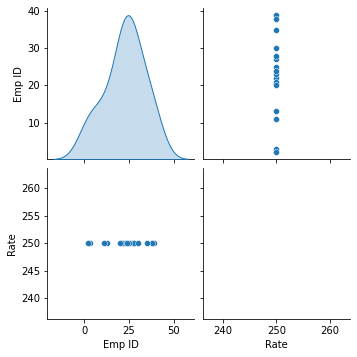

In [113]:
import seaborn as sns

if processed_df is not None:
    sns.pairplot(summary_df, diag_kind = 'kde')
